# **DATA CLEANING and PRE-PROCESSING**

***What socioeconomic, limnological, ichthyological factors predict the success of stocked walleye populations in the midwest?***

---

### **Merging Datasets**
---

First, the walleye dataset was imported and unneccesary columns were dropped.

In [4]:
import pandas as pd

# Import walleye dataset
wae = pd.read_csv("wae_release_impute.csv")

# Rename and drop columns to prepare for merging
wae = wae.rename(columns={"site_id": "lake_nhdid"})
wae = wae.drop(columns={"lake_lat_decdeg", "lake_lon_decdeg", "wae_cpe", "wae_yoy", "wae_age_1", "wae_age_2",})
wae["lake_nhdid"] = wae["lake_nhdid"].astype(str)
wae["lake_nhdid"] = wae["lake_nhdid"].str.replace('nhdhr_', '')
wae.head()

,lake_nhdid,percent_bass,state,stock_size,wae_mod_lifestage,wae_repro,year,lake_waterarea_ha,lake_shorelinedevfactor,gdd_wtr_5c,tsi,trophic,stock_density,wae_mod,lake_maxdepth_m,rsvr
0,120020200,0.330494,MN,large_fingerling,age_1,none,2009,95.980717,2.149382,2581.430555,68.749048,eutrophic,48.822306,0.437599,8.817787,RSVR
1,120019962,0.490824,MN,large_fingerling,age_1,none,2006,237.869015,1.214206,2477.367889,47.131189,mesotrophic,65.477212,0.393365,14.534596,NL
2,120019969,0.417561,MN,large_fingerling,age_1,none,2008,158.342809,1.322031,2235.214476,56.663962,eutrophic,109.856584,0.060032,11.272998,NL
3,120018925,0.456687,MN,large_fingerling,age_1,combo,2006,618.350122,1.507848,2397.408926,49.091466,mesotrophic,177.417285,0.134281,16.076155,NL
4,72863677,0.470768,MN,large_fingerling,age_1,combo,2005,306.643767,1.973882,2437.631125,44.169021,mesotrophic,17.166499,0.255924,20.396532,NL


The link dataset was imported to match the FIPS code to lake_nhdid which is provided in the walleye dataset.

In [6]:
# Read link dataset
link = pd.read_csv("lake_link.csv")
link = link[["lake_nhdid", "lake_namelagos", "lake_countyfips", "lake_lat_decdeg", "lake_lon_decdeg"]]

C:\Users\crgod\AppData\Local\Temp\ipykernel_36120\947576741.py:2: DtypeWarning: Columns (1,20,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  link = pd.read_csv("lake_link.csv")


The walleye dataset and the link datasets were merged on lake_nhdid.

In [8]:
# Merge walleye dataset and link dataset
merge1 = pd.merge(wae, link, on = "lake_nhdid", how='left')

# Drop duplicates and reset index
merge1 = merge1.drop_duplicates(subset=['lake_nhdid', 'year'])
merge1 = merge1.reset_index(drop=True)
merge1.head()

,lake_nhdid,percent_bass,state,stock_size,wae_mod_lifestage,wae_repro,year,lake_waterarea_ha,lake_shorelinedevfactor,gdd_wtr_5c,tsi,trophic,stock_density,wae_mod,lake_maxdepth_m,rsvr,lake_namelagos,lake_countyfips,lake_lat_decdeg,lake_lon_decdeg
0,120020200,0.330494,MN,large_fingerling,age_1,none,2009,95.980717,2.149382,2581.430555,68.749048,eutrophic,48.822306,0.437599,8.817787,RSVR,Lotus Lake,27019,44.876979,-93.530152
1,120019962,0.490824,MN,large_fingerling,age_1,none,2006,237.869015,1.214206,2477.367889,47.131189,mesotrophic,65.477212,0.393365,14.534596,NL,Dam Lake,27001,46.510086,-93.463757
2,120019969,0.417561,MN,large_fingerling,age_1,none,2008,158.342809,1.322031,2235.214476,56.663962,eutrophic,109.856584,0.060032,11.272998,NL,Sisabagamah Lake,27001,46.504009,-93.606602
3,120018925,0.456687,MN,large_fingerling,age_1,combo,2006,618.350122,1.507848,2397.408926,49.091466,mesotrophic,177.417285,0.134281,16.076155,NL,Portage Lake,27021,47.340434,-94.297800
4,72863677,0.470768,MN,large_fingerling,age_1,combo,2005,306.643767,1.973882,2437.631125,44.169021,mesotrophic,17.166499,0.255924,20.396532,NL,Black Water Lake; Blackwater Lake,27021,46.908691,-94.304592


The American Community Survey dataset was imported. See acs_extraction how the data was collected.

In [10]:
# Read in ACS data
acs = pd.read_csv('acs_data_cleaned.csv')

Because the ACS is performed every 5 years and the walleye dataset has various years of reporting, KNN was utilized to match the examples in the walleye dataset to the closest ACS data in terms of year. This code merges the newly created walleye dataset containing FIPS code (merge1) with ACS data to create merge2.

In [12]:
from sklearn.neighbors import NearestNeighbors

# Standardize FIPS
merge1['FIPS'] = merge1['lake_countyfips'].astype(str).str.zfill(5)
acs['FIPS'] = acs['FIPS'].astype(str).str.zfill(5)

# Ensure 'year' exists
if 'year' not in merge1.columns:
    merge1['year'] = pd.to_datetime(merge1['sample_date'], errors='coerce').dt.year

# Prep for nearest-year match within each FIPS group
acs_sub = acs[['FIPS', 'year']].drop_duplicates().copy()
acs_sub['merge_key'] = acs_sub['FIPS'] + "_" + acs_sub['year'].astype(str)
merge1['merge_key'] = merge1['FIPS'] + "_" + merge1['year'].astype(str)

# Nearest neighbor logic
matched_rows = []
for fips in merge1['FIPS'].unique():
    target = merge1[merge1['FIPS'] == fips]
    acs_years = acs_sub[acs_sub['FIPS'] == fips]

    if acs_years.empty:
        continue

    nbrs = NearestNeighbors(n_neighbors=1).fit(acs_years[['year']])
    distances, indices = nbrs.kneighbors(target[['year']])
    closest_years = acs_years.iloc[indices.flatten()].reset_index(drop=True)

    match = target.copy()
    match['matched_year'] = closest_years['year'].values
    matched_rows.append(match)

# Rebuild updated merge1 with matched_years
merge1_nearest = pd.concat(matched_rows, ignore_index=True)

# Merge on FIPS and matched_year instead of exact year
merge2 = pd.merge(
    merge1_nearest,
    acs,
    left_on=['FIPS', 'matched_year'],
    right_on=['FIPS', 'year'],
    how='left'
)
merge2.head()

,lake_nhdid,percent_bass,state,stock_size,wae_mod_lifestage,wae_repro,year_x,lake_waterarea_ha,lake_shorelinedevfactor,gdd_wtr_5c,...,merge_key,matched_year,state_abbr,year_y,County_Name,Median_Income,Below_Poverty,Population,Edu_HS_Grad,Edu_Bachelors
0,120020200,0.330494,MN,large_fingerling,age_1,none,2009,95.980717,2.149382,2581.430555,...,27019_2009,2012,MN,2012,"Carver County, Minnesota",83275.0,4679.0,91355.0,17916.0,530.0
1,120020206,0.542275,MN,large_fingerling,age_1,none,2005,1241.838775,1.269642,3005.300740,...,27019_2005,2012,MN,2012,"Carver County, Minnesota",83275.0,4679.0,91355.0,17916.0,530.0
2,120020206,0.517496,MN,large_fingerling,age_1,none,2007,1241.838775,1.269642,3002.423502,...,27019_2007,2012,MN,2012,"Carver County, Minnesota",83275.0,4679.0,91355.0,17916.0,530.0
3,120020206,0.448540,MN,large_fingerling,age_1,none,2011,1241.838775,1.269642,2792.248546,...,27019_2011,2012,MN,2012,"Carver County, Minnesota",83275.0,4679.0,91355.0,17916.0,530.0
4,120019962,0.490824,MN,large_fingerling,age_1,none,2006,237.869015,1.214206,2477.367889,...,27001_2006,2012,MN,2012,"Aitkin County, Minnesota",41191.0,1999.0,16166.0,1305.0,71.0


The distribution of year difference between the walleye stocking analysis and the ACS data was plotted.

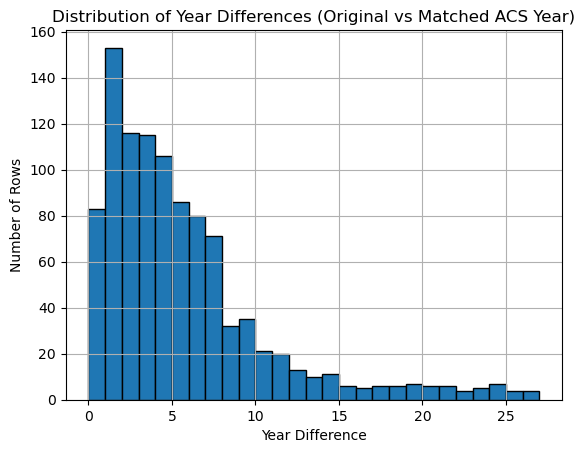

In [14]:
import matplotlib.pyplot as plt
merge2['year_diff'] = abs(merge2['year_x'] - merge2['matched_year'])
merge2['year_diff'].plot.hist(bins=range(0, merge2['year_diff'].max()+2), edgecolor='black')
plt.title("Distribution of Year Differences (Original vs Matched ACS Year)")
plt.xlabel("Year Difference")
plt.ylabel("Number of Rows")
plt.grid(True)
plt.show()

If the year difference was greater than 10, the example was dropped.

In [16]:
# Keep rows with matched ACS data within 10 years of original
df = merge2[merge2['year_diff'] <= 10].copy()
print("Filtered dataset shape:", df.shape)

Filtered dataset shape: (898, 32)


---
### **Data Cleaning**
---

Each feature was checked for missing values.

In [19]:
for i in df.columns:
    print(i, df[i].isna().sum())

lake_nhdid 0
percent_bass 0
state 0
stock_size 0
wae_mod_lifestage 0
wae_repro 0
year_x 0
lake_waterarea_ha 0
lake_shorelinedevfactor 0
gdd_wtr_5c 0
tsi 0
trophic 0
stock_density 0
wae_mod 0
lake_maxdepth_m 0
rsvr 0
lake_namelagos 1
lake_countyfips 0
lake_lat_decdeg 0
lake_lon_decdeg 0
FIPS 0
merge_key 0
matched_year 0
state_abbr 0
year_y 0
County_Name 0
Median_Income 0
Below_Poverty 0
Population 0
Edu_HS_Grad 0
Edu_Bachelors 0
year_diff 0


There was only 1 missing value, and it was for a lake name. The lake was identified by latitude and longitude and the name was imputed.

In [21]:
# Find missing lake
lat = df.loc[df['lake_namelagos'].isna(), 'lake_lat_decdeg'].values[0]
lon = df.loc[df['lake_namelagos'].isna(), 'lake_lon_decdeg'].values[0]
state = df.loc[df['lake_namelagos'].isna(), 'state'].values[0]

print("Lat:", lat)
print("Lon:", lon)
print("State:", state)
# McKarns Lake

# Impute missing lake
df.loc[df['lake_namelagos'].isna(), 'lake_namelagos'] = "McKarns Lake"
df.lake_namelagos.isna().sum()

Lat: 41.5552485865577
Lon: -84.6549472877052
State: OH


0

All other year variables besides year of stocking and year difference between the walleye data and the ACS data were dropped.

In [23]:
# Rename 'year_x' to 'year'
df.rename(columns={'year_x': 'year'}, inplace=True)

# Drop all other columns containing 'year' except 'year' and 'year_diff'
columns_to_drop = [col for col in df.columns if 'year' in col and col not in ['year', 'year_diff']]
df.drop(columns=columns_to_drop, inplace=True)

# Check remaining columns
print(df.columns.tolist())

['lake_nhdid', 'percent_bass', 'state', 'stock_size', 'wae_mod_lifestage', 'wae_repro', 'year', 'lake_waterarea_ha', 'lake_shorelinedevfactor', 'gdd_wtr_5c', 'tsi', 'trophic', 'stock_density', 'wae_mod', 'lake_maxdepth_m', 'rsvr', 'lake_namelagos', 'lake_countyfips', 'lake_lat_decdeg', 'lake_lon_decdeg', 'FIPS', 'merge_key', 'state_abbr', 'County_Name', 'Median_Income', 'Below_Poverty', 'Population', 'Edu_HS_Grad', 'Edu_Bachelors', 'year_diff']


Proportions for ACS features were created.

In [25]:
# Create proportions
df['prop_below_poverty'] = df['Below_Poverty'] / df['Population']
df['prop_hs_grad'] = df['Edu_HS_Grad'] / df['Population']
df['prop_bachelors'] = df['Edu_Bachelors'] / df['Population']

# Drop columns
columns_to_drop = ['Below_Poverty', 'Edu_HS_Grad', 'Edu_Bachelors']
df.drop(columns=columns_to_drop, inplace=True)

Outliers were analyzed.

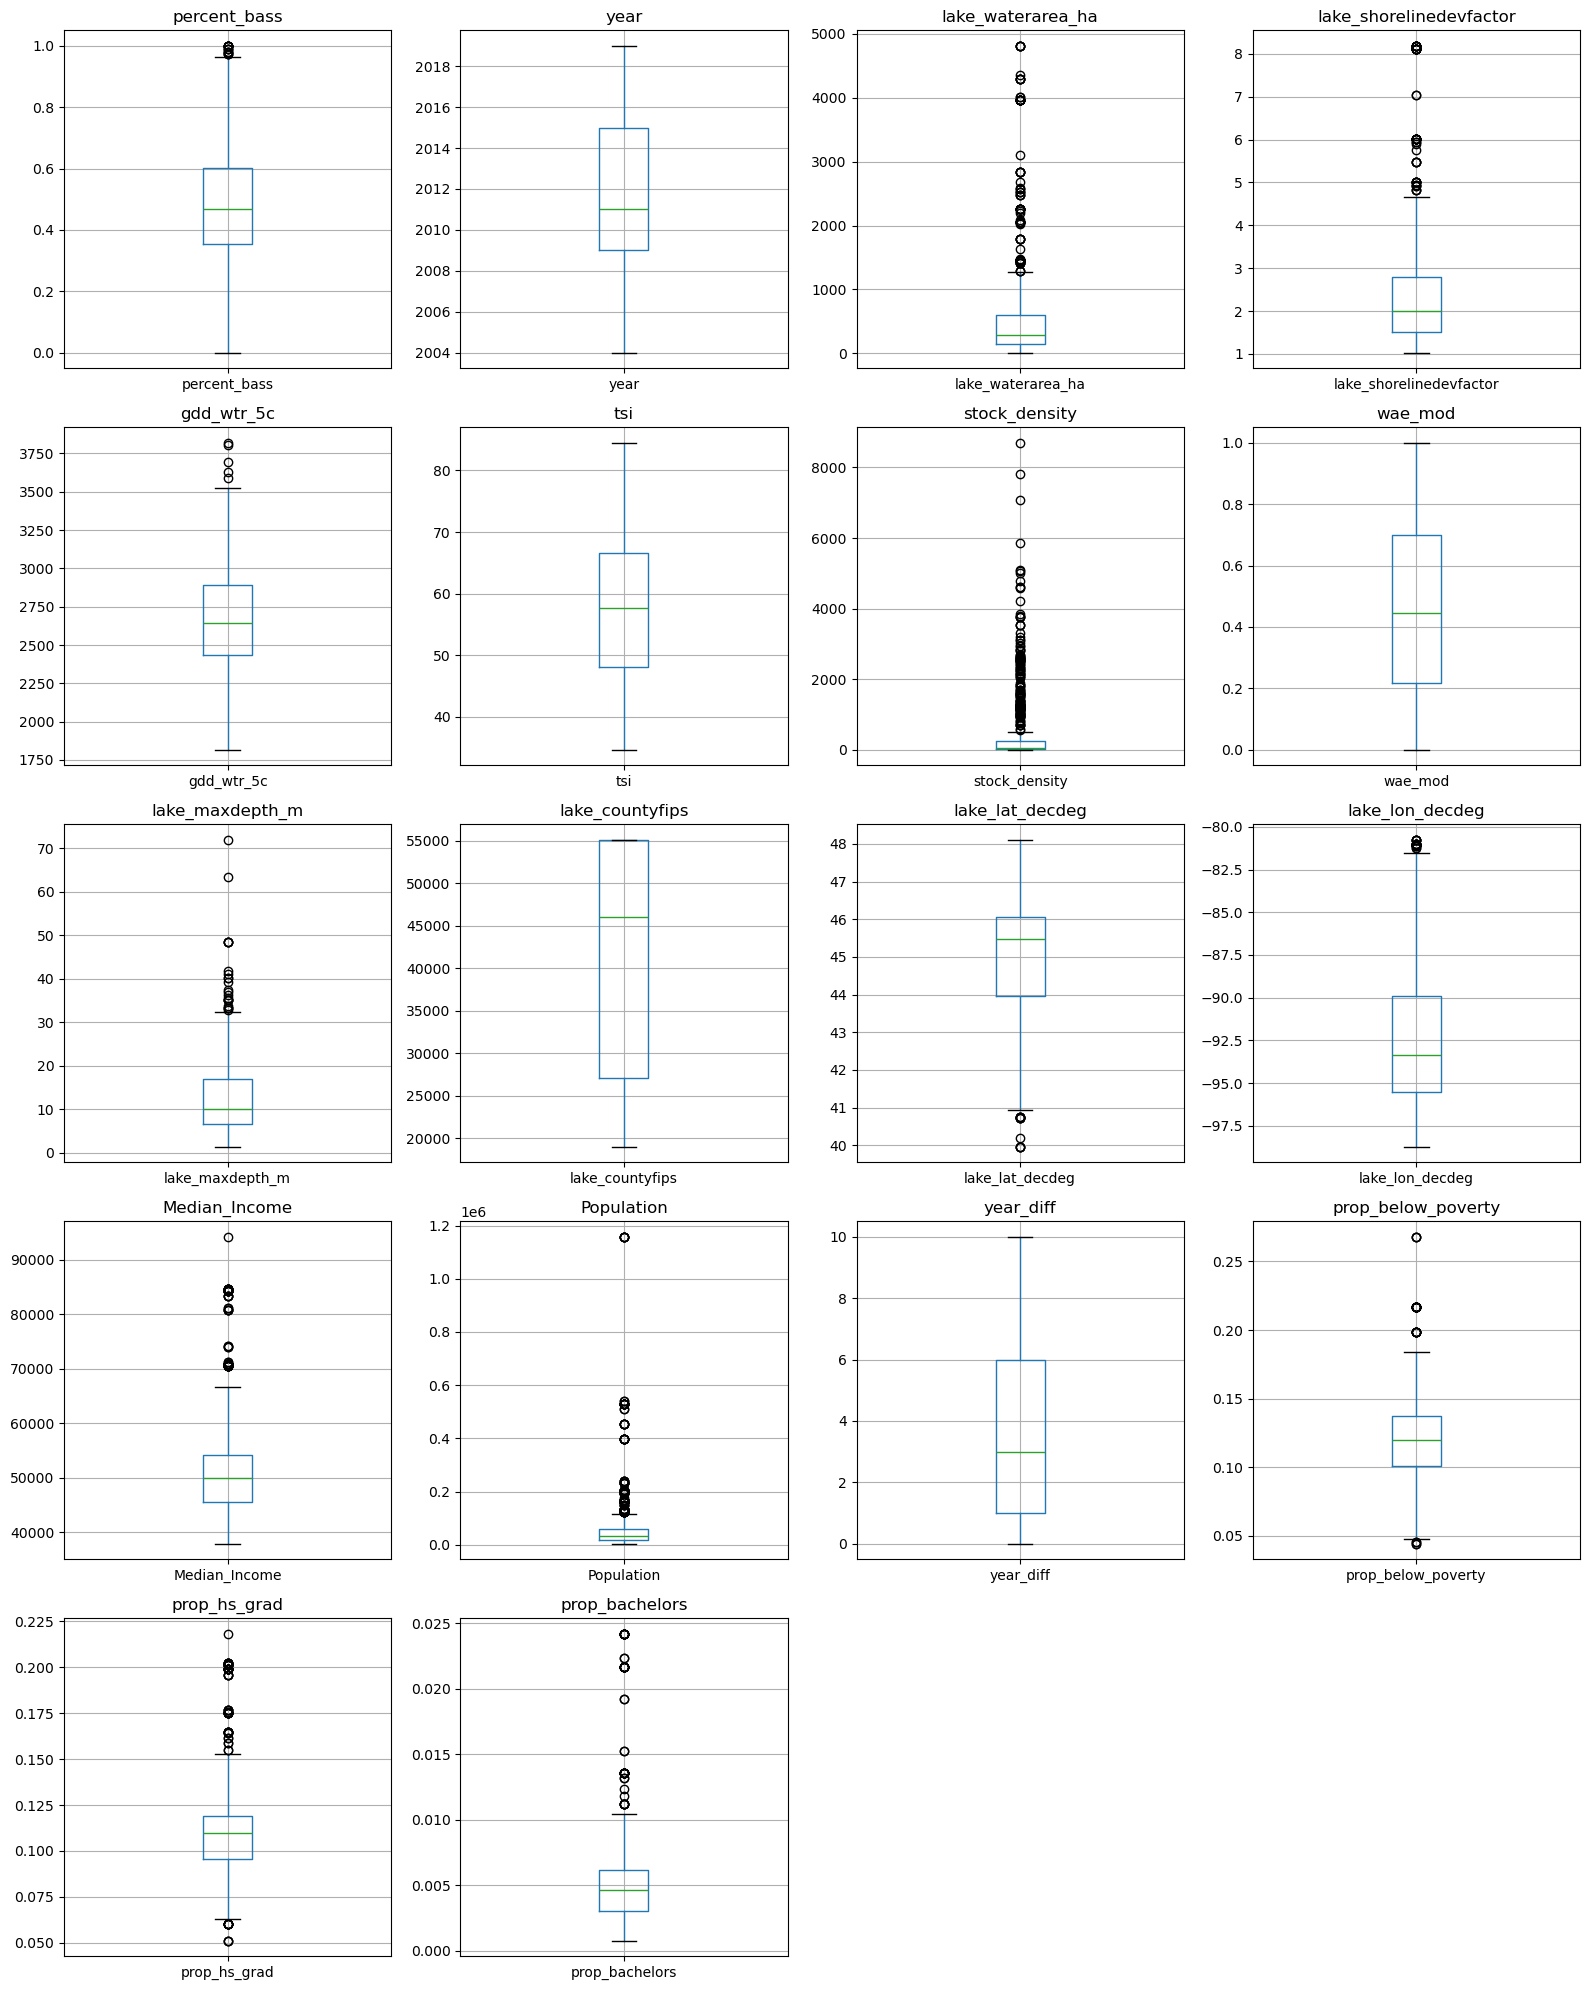

In [27]:
import matplotlib.pyplot as plt

# Select all numeric columns (float and int types)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Set up a grid layout for subplots
cols_per_row = 4
rows = (len(numeric_cols) + cols_per_row - 1) // cols_per_row
plt.figure(figsize=(cols_per_row * 4, rows * 4))  # Adjust size as needed

# Loop through each column and plot its boxplot
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols_per_row, i)
    df.boxplot(column=col)
    plt.title(col)
    plt.tight_layout()

plt.show()

Analyze extreme outlier for population. This population of this county makes logical sense as it houses the Twin Cities.

In [29]:
# Find the maximum population value
max_population = df['Population'].max()

# Filter the DataFrame to rows with that max value
extreme_population_rows = df[df['Population'] == max_population]

# Select relevant columns to display
extreme_population_rows[
    ['County_Name', 'state', 'Population', 'Median_Income', 
     'prop_below_poverty', 'prop_hs_grad', 'prop_bachelors']
]

,County_Name,state,Population,Median_Income,prop_below_poverty,prop_hs_grad,prop_bachelors
78,"Hennepin County, Minnesota",MN,1158039.0,63559.0,0.123606,0.202326,0.011171
79,"Hennepin County, Minnesota",MN,1158039.0,63559.0,0.123606,0.202326,0.011171
80,"Hennepin County, Minnesota",MN,1158039.0,63559.0,0.123606,0.202326,0.011171
81,"Hennepin County, Minnesota",MN,1158039.0,63559.0,0.123606,0.202326,0.011171
82,"Hennepin County, Minnesota",MN,1158039.0,63559.0,0.123606,0.202326,0.011171
83,"Hennepin County, Minnesota",MN,1158039.0,63559.0,0.123606,0.202326,0.011171


The outliers were considered contextually apropriate.

In [31]:
# 1. Force all column names to lowercase
df.columns = df.columns.str.lower()

# 2. Standardize text formatting in key categorical columns
df['state'] = df['state'].str.strip().str.upper()
df['rsvr'] = df['rsvr'].str.strip().str.title()
df['stock_size'] = df['stock_size'].str.strip().str.title()

# 3. Identify rare categories (appearing fewer than 5 times)
rare_stock_sizes = df['stock_size'].value_counts()[df['stock_size'].value_counts() < 5]
rare_trophic = df['trophic'].value_counts()[df['trophic'].value_counts() < 5]
rare_rsvr = df['rsvr'].value_counts()[df['rsvr'].value_counts() < 5]

print("Rare stock_size categories:", rare_stock_sizes.to_dict())
print("Rare trophic categories:", rare_trophic.to_dict())
print("Rare rsvr categories:", rare_rsvr.to_dict())

# 4. Check for invalid lat/lon ranges (Midwest USA expected)
geo_issues = df[
    (df['lake_lat_decdeg'] < 35) | (df['lake_lat_decdeg'] > 50) |
    (df['lake_lon_decdeg'] > -80) | (df['lake_lon_decdeg'] < -100)
]

print("Geolocation issues found:", geo_issues[['lake_nhdid', 'lake_lat_decdeg', 'lake_lon_decdeg']])

Rare stock_size categories: {}
Rare trophic categories: {}
Rare rsvr categories: {}
Geolocation issues found: Empty DataFrame
Columns: [lake_nhdid, lake_lat_decdeg, lake_lon_decdeg]
Index: []


In [32]:
df.to_csv('cleaned_data.csv', index=False)